# Matrix Multiplication From the Foundations

In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Download Data

In [2]:
# Downloading the MNIST dataset
MNIST_URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
# Double checking the location of download
!ls -l data

total 16656
-rw-r--r-- 1 bchaudhry bchaudhry 17051982 May 16 17:55 mnist.pkl.gz


In [5]:
# Loading the data as a tuple of tuples
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

Since we aren't allowed to use Numpy, Pandas, PyTorch this early on, we'll have to work with the standard Python toolkit.

In [7]:
lst_1 = list(x_train[0])
vals = lst_1[200:222]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98046875,
 0.36328125,
 0.3203125,
 0.3203125,
 0.21875,
 0.15234375,
 0.0,
 0.0,
 0.0]

In [8]:
len(lst_1)

784

Since we can't work with matrices at the moment, we will need to convert our list of 784 elements into lists of 28x28. To do that, we can use `chunks`

In [9]:
# Creating a function for chunks
def chunks(x, sz):
    # Loop through values from 0 to length of the list based on size
    # Yield(iterator) allows us to keep returning values till all elements in the
    # input have finished.
    for i in range(0, len(x), sz): yield x[i:i + sz]

In [10]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125],
 [0.98828125, 0.98828125, 0.98828125, 0.98046875, 0.36328125],
 [0.3203125, 0.3203125, 0.21875, 0.15234375, 0.0],
 [0.0, 0.0]]

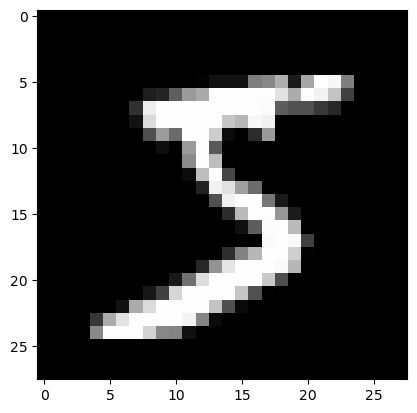

In [11]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst_1, 28)));

We can continue working with iterators using the library `itertools`

In [12]:
from itertools import islice

In [13]:
it = iter(vals)
islice(it, 5)

`islice` allows us to move through our data chunks based on the step value. Once there is no more data remaining in the chunks, it will return an empty list.

In [14]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [15]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [16]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98046875, 0.36328125]

In [17]:
list(islice(it, 5))

[0.3203125, 0.3203125, 0.21875, 0.15234375, 0.0]

In [18]:
list(islice(it, 5))

[0.0, 0.0]

In [19]:
list(islice(it, 5))

[]

In [20]:
it = iter(lst_1)
img = list(iter(lambda: list(islice(it, 28)), []))

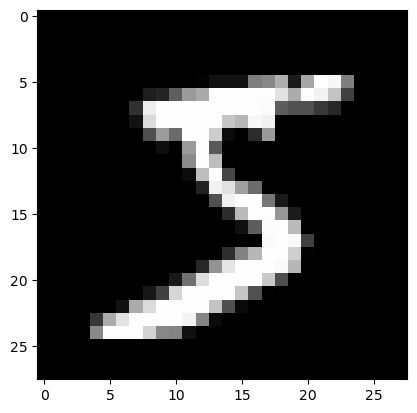

In [21]:
plt.imshow(img);

## Creating a Matrix and Tensor

In [22]:
# Indexing into an image for demo purposes
img[20][15]

0.98828125

In [23]:
# Let's create a class to work with matrices
# At first, this will only return the first and second indeces of an image
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [24]:
# Testing
m = Matrix(img)
m[20, 15]

0.98828125

We are now allowed to use the PyTorch `tensor` feature.

In [26]:
from torch import tensor

In [28]:
# Testing
tensor([1,2,3,4])

torch.Size([4])

In [33]:
# Loading image to Tensor
tens = tensor(img)
tens.shape, tens[20, 15]

(torch.Size([28, 28]), tensor(0.9883))

In [34]:
# Mapping train and valid to a tensor
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [42]:
imgs = x_train.reshape((-1, 28, 28))
imgs.shape

torch.Size([50000, 28, 28])

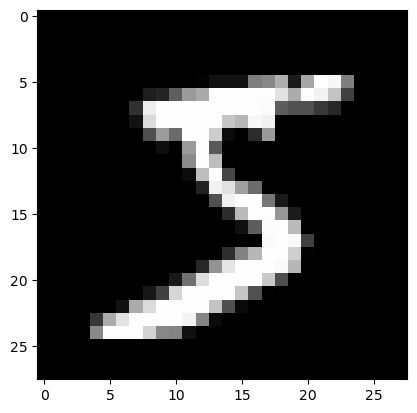

In [43]:
plt.imshow(imgs[0]);

In [44]:
# Indexing into our tensor
imgs[0, 20, 15]

tensor(0.9883)

In [48]:
num_imgs, cols = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [51]:
%time min(y_train), max(y_train)

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 148 ms


(tensor(0), tensor(9))

In [52]:
%time y_train.min(), y_train.max()

CPU times: user 7.5 ms, sys: 627 µs, total: 8.13 ms
Wall time: 829 µs


(tensor(0), tensor(9))

## On Random Numbers

Although we can use the random number generator in Python, we will opt to do it the hard way. 

This is based on the **Wichmann Hill** algorithm.

In [53]:
# Creating our custom pseudo random number generator
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x) + 1, int(y) + 1, int(z) + 1

In [54]:
# Testing
seed(91737649164947)
rnd_state

(15508, 3633, 9043)

In [55]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x, y, z
    return (x / 30269 + y / 30307 + z / 30323) % 1.0

In [56]:
rand(), rand(), rand()

(0.9260572151726816, 0.2761706728795734, 0.9273684118432157)

In [58]:
# Fork's a process, which returns 0 in the child and the child's process id
# in the parent. 
# Right now, we are seeing similar random numbers because both the parent and the child
# are copies of each other.
if os.fork(): 
    print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9768276103697152
In child: 0.9768276103697152


Let's see whether our go to libraries correctly re-initialize the random stream in the forked versions.

In [59]:
# Checking PyTorch's version.
if os.fork(): 
    print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.7244])
In child: tensor([0.7244])


In [60]:
# Checking Numpy
import numpy as np
if os.fork(): 
    print(f'In parent: {np.random.rand(1)}')
else:
    print(f'In child: {np.random.rand(1)}')
    os._exit(os.EX_OK)

In parent: [0.76058175]
In child: [0.76058175]


In [62]:
# Checking base Python
from random import random
if os.fork(): 
    print(f'In parent: {random()}')
else:
    print(f'In child: {random()}')
    os._exit(os.EX_OK)

In parent: 0.5011186988693281
In child: 0.15813953603163355


Python's implementation is the only one that gets it right!!

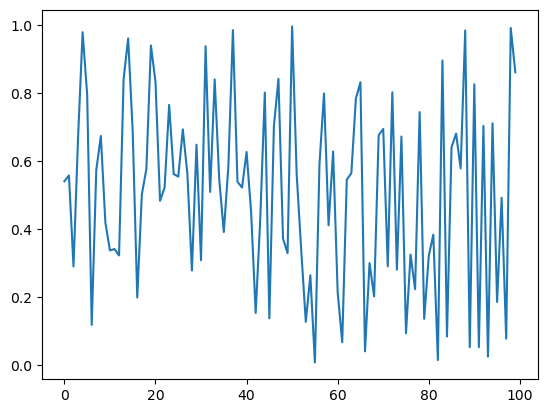

In [63]:
plt.plot([rand() for _ in range(100)]);

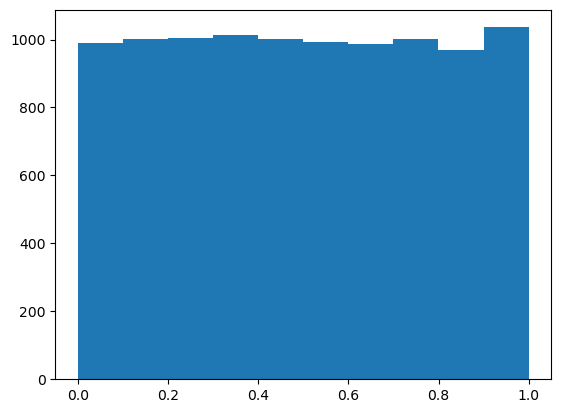

In [65]:
plt.hist([rand() for _ in range(10000)]);

In [66]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.43 ms ± 866 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
%timeit -n 10 torch.randn(784, 10)

The slowest run took 16.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100 µs ± 166 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
